# Setup

In [1]:
from multiprocessing import cpu_count
n_jobs = cpu_count() - 1

In [ ]:
import joblib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.base import clone
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Exercise 1

Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

In [11]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = (X/256.).astype(np.float32)
y = y.astype(np.uint8)

In [12]:
train_samples = 60000
X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

In [14]:
pipeline_model = Pipeline([('clf',KNeighborsClassifier())])

In [15]:
param_grid = [
    {'clf':[KNeighborsClassifier()], 'clf__weights': ["uniform", "distance"], 'clf__n_neighbors': [3, 4, 5]},
    {'clf':[SVC()], 'clf__kernel':['linear', 'rbf'], 'clf__C': [1., 10., 100., 1000.], 'clf__gamma':[0.01, 0.1, 1.]},
    {'clf':[RandomForestClassifier()], 'clf__n_estimators': [10, 100, 1000], 'clf__max_depth':[None, 5, 10]},
    {'clf':[GradientBoostingClassifier()], 'clf__n_estimators': [10, 100, 1000], 'clf__learning_rate':[0.01, 0.1, 0.25]},
    {'clf':[MLPClassifier(early_stopping=True)], 'clf__hidden_layer_sizes':[(16,), (16,16,), (32,16,),(32,32,)], 'clf__alpha':[0.000001, 0.00001, 0.0001], 'clf__learning_rate':['invscaling', 'adaptive']}
]

In [15]:
grid = GridSearchCV(pipeline_model, param_grid, scoring="accuracy", cv=5, n_jobs=n_jobs, verbose=2)

In [16]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done  19 tasks      | elapsed: 50.2min
/home/philipp/anaconda3/envs/tf2/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=11)]: Done 140 tasks      | elapsed: 1390.8min
[Parallel(n_jobs=11)]: Done 360 out of 360 | elapsed: 2733.1min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('clf',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weights='uniform'))],
                                verbose=False),
             iid='deprecated', n_jobs=11,
             param_grid=[{'clf': [KNeighborsClassifier(algorithm='auto',
                                                       leaf_size=30,
                                                       metric='minkowski'...
         

In [19]:
joblib.dump(grid, 'grid.pkl', compress=1)

['grid.pkl']

In [17]:
with open('grid.pkl', 'rb') as f:
    grid = joblib.load(f)

In [ ]:
grid.best_estimator_

In [22]:
y_test_pred = grid.predict(X_test)

In [23]:
print(accuracy_score(y_test, y_test_pred))

0.9833


# Exercise 2

Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel. Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

In [25]:
X,y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = (X/256.).astype(np.float32)
y = y.astype(np.uint8)

In [26]:
train_samples = 60000
X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

In [27]:
def shift_image(image, direction="left"):
    assert direction in ["left", "right", "up", "down"], "direction has to be one of 'left', 'right', 'up', or 'down'"
    r, c = image.shape
    if direction == "left":
        return np.c_[image[:, 1:], np.zeros((r,1), dtype="float32")]
    elif direction == "right":
        return np.c_[np.zeros((r,1), dtype="float32"), image[:, :c-1]]
    elif direction == "up":
        return np.r_[image[1:], np.zeros((1,c), dtype="float32")]
    else:
        return np.r_[np.zeros((1,c), dtype="float32"), image[:r-1]]

In [28]:
X_train_augmented = []
y_train_augmented = []

for image, label in zip(X_train, y_train):
    X_train_augmented.append(image)
    y_train_augmented.append(label)
    for direction in ["left", "right", "up", "down"]:
        X_train_augmented.append(shift_image(image.reshape(28,28), direction).reshape(-1))
        y_train_augmented.append(label)

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

### Train best model

In [30]:
with open('grid.pkl', 'rb') as f:
    grid = joblib.load(f)

In [33]:
model = clone(grid.best_estimator_)

In [37]:
y_test.shape

(10000,)

In [34]:
model.fit(X_train_augmented, y_train_augmented)

Pipeline(memory=None,
         steps=[('clf',
                 SVC(C=10.0, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.01,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [38]:
y_test_pred = model.predict(X_test)

In [39]:
accuracy_score(y_test, y_test_pred)

0.9889

# Exercise 3

Tackle the Titanic dataset. A great place to start is on Kaggle.

In [3]:
train = pd.read_csv('../datasets/titanic/train.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### PassengerID

In [6]:
len(train.PassengerId.unique())

891

Not a useful feature for classification. Only needed for submission

### Survived

In [72]:
train.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

### Families

Did families survive or die together?

In [73]:
train['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [79]:
train['Family_Name'] = train['Name'].apply(lambda s: s.split(', ')[0])
train['Title'] = train['Name'].apply(lambda s: s.split(', ')[1].split(' ')[0])

In [82]:
train['Family_Name'].value_counts()

Andersson       9
Sage            7
Carter          6
Skoog           6
Panula          6
               ..
Lester          1
Peters          1
Plotcharsky     1
Vanden Steen    1
Soholt          1
Name: Family_Name, Length: 667, dtype: int64

In [83]:
train['Title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Major.         2
Col.           2
the            1
Ms.            1
Mme.           1
Lady.          1
Capt.          1
Don.           1
Sir.           1
Jonkheer.      1
Name: Title, dtype: int64

The target variable. Only required processing it to translate the integer column to a float

### Cabin

In [ ]:
train['Deck'] = train['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else s)

Text(0.5, 1.0, 'Survival rates for different decks')

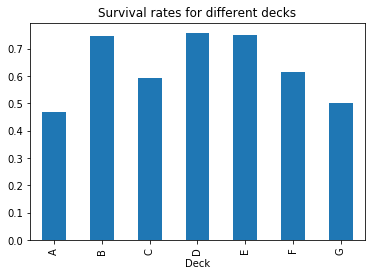

In [26]:
train[['Deck', 'Survived']].groupby('Deck')['Survived'].mean().plot(kind='bar')
plt.title('Survival rates for different decks')

In [25]:
# Deck T seems to be a data error
train['Deck'].replace('T', None, inplace=True)

In [29]:
# Are people with the same ticket on the same Deck?
train[['Ticket', 'Deck']].groupby('Ticket')['Deck'].transform('nunique').value_counts()

0    677
1    210
2      4
Name: Deck, dtype: int64

In [32]:
train['Deck'].isnull().sum()

688

In [70]:
train['Deck'].fillna(train.groupby('Ticket')['Deck'].transform(lambda x: x.value_counts().index[0] if x.value_counts().size > 0 else np.nan), inplace=True)

In [71]:
train['Deck'].value_counts(dropna=False)

NO TICKET    677
C             67
B             48
E             33
D             33
A             15
F             14
G              4
Name: Deck, dtype: int64

In [50]:
tickets_nodeck = train.loc[train['Deck'].isnull()]['Ticket']
tickets_deck = train.loc[train['Deck'].notnull()]['Ticket']
print(tickets_deck[tickets_deck.isin(tickets_nodeck)])

128           2668
269       PC 17760
297         113781
305         113781
318          36928
325       PC 17760
498         113781
544       PC 17761
550          17421
581          17421
679       PC 17755
698          17421
700       PC 17757
716       PC 17757
737       PC 17755
741          19877
772    S.O./P.P. 3
Name: Ticket, dtype: object


In [67]:
test = train.loc[train['Ticket']=='2668']

In [68]:
test.groupby(['Ticket'])['Deck'].agg(lambda x: x.value_counts().index[0])

Ticket
2668    F
Name: Deck, dtype: object

In [69]:
test['Deck'].fillna(test.groupby(['Ticket'])['Deck'].transform(lambda x: x.value_counts().index[0]))

128    F
533    F
Name: Deck, dtype: object

In [47]:
tickets_deck

1      PC 17599
3        113803
6         17463
10      PP 9549
11       113783
         ...   
871       11751
872         695
879       11767
887      112053
889      111369
Name: Ticket, Length: 203, dtype: object

### Pclass

In [8]:
train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

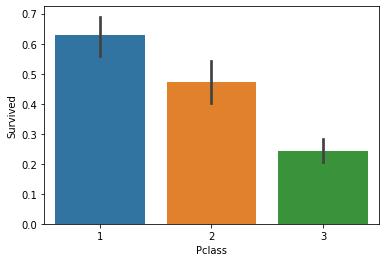

In [9]:
sns.barplot(x='Pclass', y='Survived', data=train)

The class could correlate with age, as older people tend to be wealthier. Older passengers had a higher survival rate, as they were helped more.

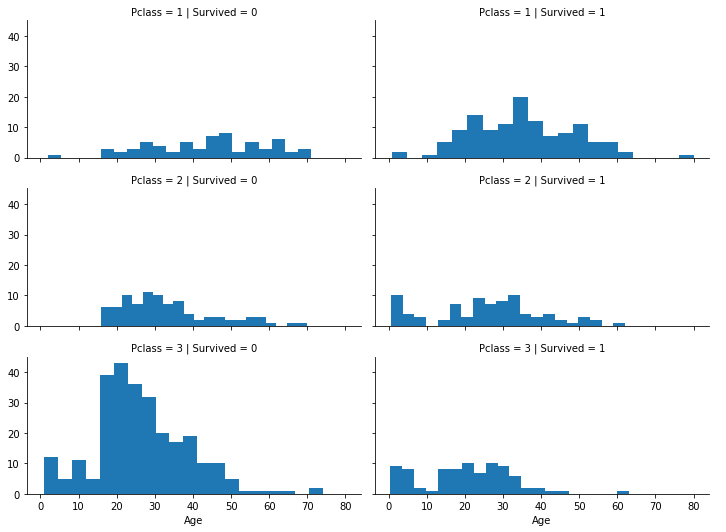

In [12]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', size=2.5, aspect=2.0)
grid.map(plt.hist, 'Age', bins=20)
grid.add_legend()

The class could also correlate with the Deck, as higher classes tend to be on upper decks. Passengers on higher decks survived more frequently, as they were closer to the life boats.

C    59
B    47
D    33
E    32
A    15
F    13
G     4
T     1
Name: Deck, dtype: int64

# Exercise 4

Build a spam classifier (a more challenging exercise):
* Download examples of spam and ham from Apache SpamAssassin’s public datasets.
* Unzip the datasets and familiarize yourself with the data format.
* Split the datasets into a training set and a test set.
* Write a data preparation pipeline to convert each email into a feature vector.
    
Your preparation pipeline should transform an email into a (sparse) vector that indicates the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.

You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this). Finally, try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.